## Coding Exercise #0706

### 1. Convolutional Neural Network (grayscale images):

In [1]:
import numpy as np
import tensorflow as tf
import logging
import matplotlib.pyplot as plt
%matplotlib inline

#### 1.1. Download the MNIST data:

In [2]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)                                   # Set the verbosity lebel high so that most warnings are ignored.
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data()
type(mnist_train_images)

11490434/11490434 [==============================] - 0s 0us/step


numpy.ndarray

In [3]:
# for mnist_train_images and mnist_test_images shape is already = [batch_size, in_height, in_width, in_channels]
mnist_train_images = mnist_train_images.astype('float32') / 255
mnist_test_images = mnist_test_images.astype('float32') / 255

mnist_train_images = np.expand_dims(mnist_train_images, -1)
mnist_test_images = np.expand_dims(mnist_test_images, -1)

mnist_train_labels = tf.keras.utils.to_categorical(mnist_train_labels, 10)                # one-hot encoding labels
mnist_test_labels = tf.keras.utils.to_categorical(mnist_test_labels, 10)

#### 1.2. Take a look at the dataset:

In [4]:
print("Training data X shape: {}".format((mnist_train_images).shape))
print("Training data y shape: {}".format((mnist_train_labels).shape))
print("Training data cases: {}".format(mnist_train_images.shape[0]))
print("\n")
print("Testing data X shape: {}".format((mnist_test_images).shape))
print("Testing data y shape: {}".format((mnist_test_labels).shape))
print("Testing data cases: {}".format(mnist_test_images.shape[0]))

Training data X shape: (60000, 28, 28, 1)
Training data y shape: (60000, 10)
Training data cases: 60000


Testing data X shape: (10000, 28, 28, 1)
Testing data y shape: (10000, 10)
Testing data cases: 10000


Visualization.

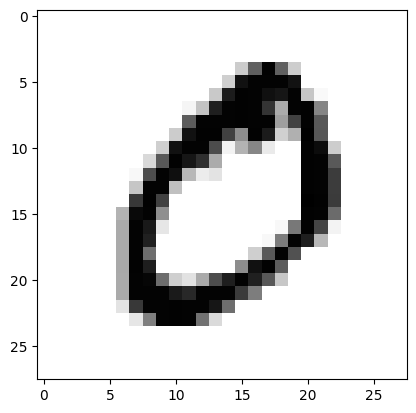

In [5]:
i_image= 1                                                      # Image index. You can change it at will.
a_single_image = mnist_train_images[i_image].reshape(28,28)     #  Reshape as a 2D array.
plt.imshow(1-a_single_image, cmap='gist_gray')                  #  Display as grayscale image.
plt.show()

In [6]:
# Check for the minimum and maximum pixel value.
# The data has been min-max-scaled already!
print("MIN : {}".format(a_single_image.min()))
print("MAX : {}".format(a_single_image.max()))

MIN : 0.0
MAX : 1.0


#### 1.3. Define the hyperparameters:

In [7]:
batch_size = 8
n_epochs  = 10001
learn_rate = 0.0001
drop_prob = 0.5                                     # For the dropout layer.

#### 1.4. Define the Variables:

The configuration of the first convolution layer is as following:
- Kernel height = 5.
- Kernel width = 5.
- In_chanels = 1 (gray scale).
- Out_channels = 32 (number of feature maps).

We need Variables with the folllowing shapes:
- Shape of the weight matrix = [kernel_height, kernel_width, in_channels, out_channels].
- Shape of the bias = [out_channels].

In [8]:
# Variables are defined according to the specifications mentioned above.
W1 = tf.Variable(initial_value=tf.random.normal([5,5,1,32], mean=0, stddev=0.1))
b1 = tf.Variable(initial_value=tf.fill([32], 0.1))

The configuration of the second convolution layer is as following:
- Kernel height = 5.
- Kernel width = 5.
- In_chanels = 32 (out_channels from the previous convolution layer).
- Out_channels = 64 (number of feature maps).

Again, we need Variables with the folllowing shapes:
- Shape of the weight matrix = [kernel_height, kernel_width, in_channels, out_channels].
- Shape of the bias = [out_channels].

In [9]:
# Variables are defined according to the specifications mentioned above.
W2 = tf.Variable(initial_value=tf.random.normal([5,5,32,64], mean=0, stddev=0.1))
b2 = tf.Variable(initial_value=tf.fill([64], 0.1))

We do the following considerations for the flattened fully connected layer:
- We will apply convolution twice with padding and there will be no image size reduction.
- We will also apply max pooling twice with stride = 2 (vertically and horizontally).
- At each max pooling with stride = 2, the image size is halved. Thus, (28/2)/2 = 7 will be the size (vertical and horizontal) of the resulting final image.   
- In the previous layer there were 64 output channels (feature maps).
- Considering all these facts, there should be 7x7x64 = 3136 nodes in the flattened layer.
- Finally, we will shrink the output from this layer to 1024.

In [10]:
# Variables are defined according to the specifications mentioned above.
W3 = tf.Variable(initial_value=tf.random.normal([3136,1024], mean=0, stddev=0.1))
b3 = tf.Variable(initial_value=tf.fill([1024], 0.1))

We do the following considerations for the final output layer:
- There are 1024 nodes to match with the output from the previous layer.
- We should shrink the output once more because there are 10 different labels (digits 0~9).

In [11]:
# Variables are defined according to the specifications mentioned above.
W4 = tf.Variable(initial_value=tf.random.normal([1024,10], mean=0, stddev=0.1))
b4 = tf.Variable(initial_value=tf.fill([10], 0.1))

#### 1.5. Define the deep learning model (CNN):

Explanation of the arguments:
- padding = 'SAME' to apply a padding. padding = 'VALID' to apply no padding.
- ksize = [1, kernel_height, kernel_width, 1]
- strides = [1, stride_vertical, stride_horizontal,1]

In [12]:
def model(X, drop_probability):
  # 1st Convolution layer.
  y1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME') + b1
  conv1 = tf.nn.relu(y1)                           # Apply the ReLu activation function.
  # 1st Pooling layer.
  pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

  # 2nd Convolution layer.
  y2 = tf.nn.conv2d(pool1, W2, strides=[1, 1, 1, 1], padding='SAME') + b2
  conv2 = tf.nn.relu(y2)                           # Apply the ReLu activation function.
  # 2nd Pooling layer.
  pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

  # Flattened full layer.
  conv2_flattened = tf.reshape(pool2, [-1,3136])   # 7x7x64 = 3136.
  y3 = tf.matmul(conv2_flattened, W3) + b3
  full_layer = tf.nn.relu(y3)                      # Apply the ReLu activation function.

  # Dropout layer.
  dropout_layer = tf.nn.dropout(full_layer, rate = drop_probability)

  # Output layer.
  y_model = tf.matmul(dropout_layer, W4) + b4      # No activation function. Softmax at the output layer is optional.
  return y_model

#### 1.6. Define the loss function and the optimizer:

In [13]:
def loss_fn(y_true, y_pred):
  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))   # loss = Cross Entropy.

In [14]:
optimizer = tf.optimizers.Adam(learning_rate = learn_rate)

#### 1.7. Training and Testing:

In [15]:
@tf.function
def train_step(X, y, drop_probability):
    with tf.GradientTape() as tape:
        y_pred = model(X, drop_probability)
        loss = loss_fn(y, y_pred)
    gradients = tape.gradient(loss, [W1, W2, W3, W4, b1, b2, b3, b4])
    optimizer.apply_gradients(zip(gradients, [W1, W2, W3, W4, b1, b2, b3, b4]))

# To replicate functionalities of tensorflow v1.* next_batch():
train_dataset = tf.data.Dataset.from_tensor_slices((mnist_train_images, mnist_train_labels))  # join together images and labels
train_dataset = train_dataset.repeat().batch(batch_size)                                      # yield batches that straddle epoch boundaries
# train_dataset = train_dataset.batch(batch_size)                                             # if clear epoch separation is needed

# Training.
for i in range(n_epochs):
    batch_X, batch_y = next(iter(train_dataset))                                # Get a batch.
    train_step(batch_X, batch_y, drop_prob)
    # Testing.
    if i % 500 == 0:
        correct_predictions = tf.equal(tf.argmax(mnist_test_labels, axis=1), tf.argmax(model(mnist_test_images,0), axis=1))   # In argmax(), axis=1 means horizontal direction. No dropout for testing.
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))                                                   # Recast the Boolean as float32 first. Then calculate the mean.
        accuracy_value = accuracy.numpy()
        print("Step = {}   ,   Accuracy = {:5.3f}".format(i, accuracy_value))

Step = 0   ,   Accuracy = 0.097
Step = 500   ,   Accuracy = 0.389
Step = 1000   ,   Accuracy = 0.451
Step = 1500   ,   Accuracy = 0.395
Step = 2000   ,   Accuracy = 0.415
